In [19]:
import os
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
# Base directories
BASE_DIR = "../data/training"

IMG_FLOODED = os.path.join(BASE_DIR, "img_flooded")
MASK_FLOODED = os.path.join(BASE_DIR, "mask_flooded")

IMG_NON_FLOODED = os.path.join(BASE_DIR, "image_non_flooded")
MASK_NON_FLOODED = os.path.join(BASE_DIR, "mask_non_flooded")

# Output directory for processed tiles
PROC_DIR = "../data/Processed_v3"
os.makedirs(PROC_DIR, exist_ok=True)
for split in ["train_images", "train_masks", "val_images", "val_masks", "test_images", "test_masks"]:
    os.makedirs(os.path.join(PROC_DIR, split), exist_ok=True)

# Tile settings
TILE_SIZE = 512
FILTER_THRESHOLD = 0.98  # discard tiles with >98% background

In [21]:
def load_image(path):
    return np.array(Image.open(path))

def tile_image(img, mask, size=TILE_SIZE):
    """Split image & mask into non-overlapping tiles."""
    h, w = img.shape[:2]
    tiles = []
    for i in range(0, h, size):
        for j in range(0, w, size):
            img_t = img[i:i+size, j:j+size]
            mask_t = mask[i:i+size, j:j+size]
            if img_t.shape[0] == size and img_t.shape[1] == size:
                tiles.append((img_t, mask_t))
    return tiles

def filter_tile(mask):
    """Return True if tile has enough non-background content."""
    total = mask.size
    bg = np.sum(mask == 9)  # class 9 = background
    return (bg / total) < FILTER_THRESHOLD

In [22]:
def process_dataset(img_dir, mask_dir, label):
    img_paths = sorted(glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*")))

    all_imgs, all_masks, parent_ids, all_labels = [], [], [], []

    for img_path in tqdm(img_paths, desc=f"Tiling {label}"):
        base = os.path.splitext(os.path.basename(img_path))[0]
        mask_match = [m for m in mask_paths if base in m or base + "_lab" in m]
        if not mask_match:
            continue

        img = load_image(img_path)
        mask = load_image(mask_match[0])

        tiles = tile_image(img, mask)
        for img_t, mask_t in tiles:
            if filter_tile(mask_t):
                all_imgs.append(img_t)
                all_masks.append(mask_t)
                parent_ids.append(base)
                all_labels.append(label)

    print(f"{label}: retained {len(all_imgs)} tiles after filtering from {len(img_paths)} images")
    return all_imgs, all_masks, parent_ids, all_labels


# Run for flooded & non-flooded
flood_imgs, flood_masks, flood_ids, flood_labels = process_dataset(IMG_FLOODED, MASK_FLOODED, "flooded")
non_imgs, non_masks, non_ids, non_labels = process_dataset(IMG_NON_FLOODED, MASK_NON_FLOODED, "nonflooded")

# Merge all
all_imgs = flood_imgs + non_imgs
all_masks = flood_masks + non_masks
all_parent_ids = flood_ids + non_ids
all_labels = flood_labels + non_labels

print(f"\nTotal retained tiles: {len(all_imgs)}")

Tiling flooded: 100%|███████████████████████████| 51/51 [00:05<00:00,  8.80it/s]


flooded: retained 2165 tiles after filtering from 51 images


Tiling nonflooded: 100%|██████████████████████| 347/347 [00:31<00:00, 10.85it/s]


nonflooded: retained 7244 tiles after filtering from 347 images

Total retained tiles: 9409


In [23]:
from collections import defaultdict
import re

def get_image_id(filename):
    """Extract base ID up to '_img' for grouping tiles by parent."""
    name = os.path.basename(filename).split(".")[0]
    match = re.match(r"(.+?)_img", name)
    if match:
        return match.group(1)
    parts = name.split("_")
    return "_".join(parts[:-2]) if len(parts) > 2 else name

# Group tiles by parent image
grouped = defaultdict(list)
labels = {}

for img, mask, pid, label in zip(all_imgs, all_masks, all_parent_ids, all_labels):
    true_id = get_image_id(pid)
    grouped[true_id].append((img, mask))
    labels[true_id] = label

image_ids = list(grouped.keys())
label_list = [labels[i] for i in image_ids]

print(f"Found {len(image_ids)} unique parent images "
      f"({sum(l=='flooded' for l in label_list)} flooded, "
      f"{sum(l=='nonflooded' for l in label_list)} non-flooded)")

# Stratified split (preserve flooded/non-flooded ratio)
train_ids, temp_ids, y_train, y_temp = train_test_split(
    image_ids, label_list, test_size=0.2, stratify=label_list, random_state=42
)
val_ids, test_ids, y_val, y_test = train_test_split(
    temp_ids, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

def gather_tiles(id_list):
    imgs, masks = [], []
    for i in id_list:
        for img, mask in grouped[i]:
            imgs.append(img)
            masks.append(mask)
    return imgs, masks

train_imgs, train_masks = gather_tiles(train_ids)
val_imgs, val_masks = gather_tiles(val_ids)
test_imgs, test_masks = gather_tiles(test_ids)

def count_types(ids):
    floods = sum(labels[i] == "flooded" for i in ids)
    non = sum(labels[i] == "nonflooded" for i in ids)
    return floods, non

tr_f, tr_nf = count_types(train_ids)
va_f, va_nf = count_types(val_ids)
te_f, te_nf = count_types(test_ids)

print(f"Train: {len(train_imgs)} tiles ({len(train_ids)} parent images) "
      f"→ Flooded {tr_f}, Non-flooded {tr_nf}")
print(f"Val:   {len(val_imgs)} tiles ({len(val_ids)} parent images) "
      f"→ Flooded {va_f}, Non-flooded {va_nf}")
print(f"Test:  {len(test_imgs)} tiles ({len(test_ids)} parent images) "
      f"→ Flooded {te_f}, Non-flooded {te_nf}")

Found 371 unique parent images (50 flooded, 321 non-flooded)
Train: 7554 tiles (296 parent images) → Flooded 40, Non-flooded 256
Val:   888 tiles (37 parent images) → Flooded 5, Non-flooded 32
Test:  967 tiles (38 parent images) → Flooded 5, Non-flooded 33


In [24]:
train_set = set(train_ids)
val_set = set(val_ids)
test_set = set(test_ids)

print("Train ∩ Val:", train_set.intersection(val_set))
print("Train ∩ Test:", train_set.intersection(test_set))
print("Val ∩ Test:", val_set.intersection(test_set))

Train ∩ Val: set()
Train ∩ Test: set()
Val ∩ Test: set()


In [25]:
def save_tiles(imgs, masks, prefix):
    img_dir = os.path.join(PROC_DIR, f"{prefix}_images")
    mask_dir = os.path.join(PROC_DIR, f"{prefix}_masks")

    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    for idx, (img, mask) in enumerate(tqdm(zip(imgs, masks), total=len(imgs), desc=f"Saving {prefix}")):
        Image.fromarray(img).save(os.path.join(img_dir, f"{prefix}_{idx:05d}.jpg"))
        Image.fromarray(mask).save(os.path.join(mask_dir, f"{prefix}_{idx:05d}.png"))

save_tiles(train_imgs, train_masks, "train")
save_tiles(val_imgs, val_masks, "val")
save_tiles(test_imgs, test_masks, "test")

print("\nAll 512×512 tiles saved successfully in Processed_v3/")

Saving test: 100%|███████████████████████████| 967/967 [00:07<00:00, 135.04it/s]


All 512×512 tiles saved successfully in Processed_v3/


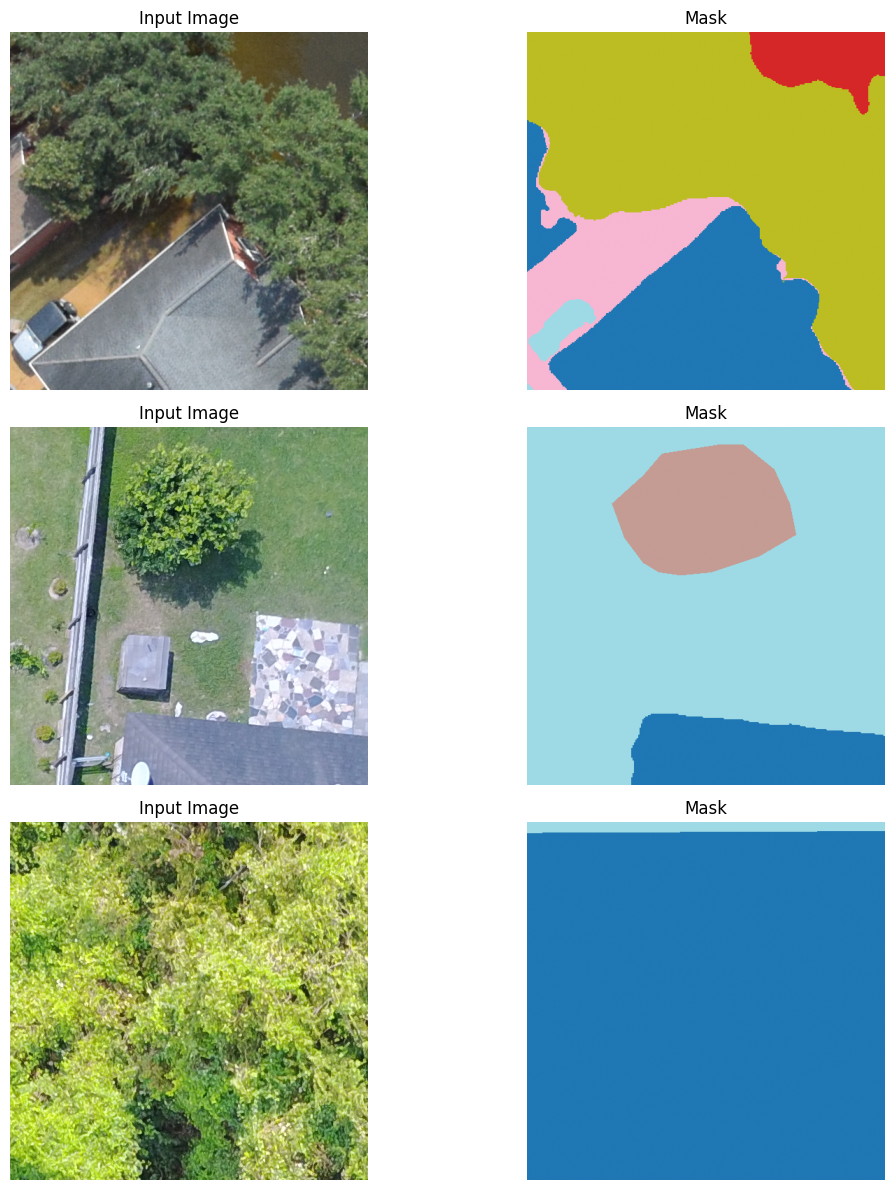

In [26]:
def visualize_random_tiles(n=3):
    samples = np.random.choice(len(train_imgs), n)
    plt.figure(figsize=(12, n * 4))
    for i, idx in enumerate(samples):
        img = train_imgs[idx]
        mask = train_masks[idx]

        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(mask, cmap="tab20")
        plt.title("Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_random_tiles(3)

In [30]:
# Class coverage check across train/val/test splits
# Works with folder structure in ../data/Processed_v3/

import os
import numpy as np
from tqdm import tqdm
from PIL import Image

def get_classes_in_split(split_dir):
    """Scan a mask directory and collect all unique class IDs."""
    class_set = set()
    for fname in tqdm(os.listdir(split_dir), desc=f"Scanning {os.path.basename(split_dir)}"):
        if fname.endswith(".png"):
            path = os.path.join(split_dir, fname)
            mask = np.array(Image.open(path))
            class_set.update(np.unique(mask))
    return sorted(class_set)

# Corrected paths based on your screenshot
split_dirs = {
    "Train": "../data/Processed_v3/train_masks",
    "Val":   "../data/Processed_v3/val_masks",
    "Test":  "../data/Processed_v3/test_masks",
}

all_classes = set()
split_classes = {}

for split, path in split_dirs.items():
    cls = get_classes_in_split(path)
    split_classes[split] = cls
    all_classes.update(cls)
    print(f"{split} classes → {cls}")

# Summary Report
print("\n=== CLASS COVERAGE SUMMARY ===")
expected = list(range(10))  # known classes [0–9]
print(f"Expected classes: {expected}")
print(f"All classes found in dataset: {sorted(all_classes)}\n")

for split, cls in split_classes.items():
    missing = set(expected) - set(cls)
    if missing:
        print(f"{split} is missing classes: {sorted(missing)}")
    else:
        print(f"{split} covers all {len(expected)} classes.")

Scanning train_masks: 100%|████████████████| 7554/7554 [00:20<00:00, 371.00it/s]


Train classes → [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]


Scanning val_masks: 100%|████████████████████| 888/888 [00:02<00:00, 401.76it/s]


Val classes → [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]


Scanning test_masks: 100%|███████████████████| 967/967 [00:02<00:00, 416.68it/s]

Test classes → [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]

=== CLASS COVERAGE SUMMARY ===
Expected classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
All classes found in dataset: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]

Train covers all 10 classes.
Val covers all 10 classes.
Test covers all 10 classes.
